In [1]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.isotonic import spearmanr



In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# Load data
train_data = pd.read_csv('./data/train_data.csv')

# Exploratory Data Analysis

In [4]:
# Basic Stats
print(train_data.describe())

        eventTimestamp         c2         c4  bidFloorPrice  sentPrice  \
count       7321633.00 7321633.00 7321633.00     7321633.00 7321633.00   
mean  1657044524161.09       5.00       5.00           0.02       0.58   
std       396424337.52       2.34       2.35           0.13       3.81   
min   1656290100421.00       1.00       1.00           0.01       0.01   
25%   1656710203520.00       3.00       3.00           0.01       0.02   
50%   1657043290386.00       5.00       5.00           0.01       0.04   
75%   1657388278715.00       7.00       7.00           0.01       0.17   
max   1657758896986.00       9.00       9.00           5.00     970.41   

          winBid    has_won  
count 7321633.00 7321633.00  
mean        4.18       0.11  
std        20.69       0.31  
min         0.01       0.00  
25%         0.09       0.00  
50%         0.51       0.00  
75%         1.54       0.00  
max      3405.72       1.00  


Missing Values


In [5]:
print(train_data.isnull().sum())

eventTimestamp                0
unitDisplayType               0
brandName                     0
bundleId                      0
appVersion                    0
correctModelName              0
countryCode                  27
deviceId                      0
osAndVersion                  0
connectionType              666
c1                            0
c2                            0
c3                            0
c4                            0
size                          0
mediationProviderVersion      0
bidFloorPrice                 0
sentPrice                     0
winBid                        0
has_won                       0
dtype: int64


Unique Values for Categorical Variables

In [6]:
for col in train_data.select_dtypes(include=['object']).columns:
    print(f"{col}: {train_data[col].nunique()} unique values")

unitDisplayType: 3 unique values
brandName: 144 unique values
bundleId: 18 unique values
appVersion: 101 unique values
correctModelName: 2568 unique values
countryCode: 168 unique values
deviceId: 40176 unique values
osAndVersion: 96 unique values
connectionType: 3 unique values
c1: 50 unique values
c3: 4 unique values
size: 6 unique values
mediationProviderVersion: 35 unique values


High cardinality columns:
* brandName
* correctModelName
* countryCode
* deviceId

Correlation Heatmap for numeric columns

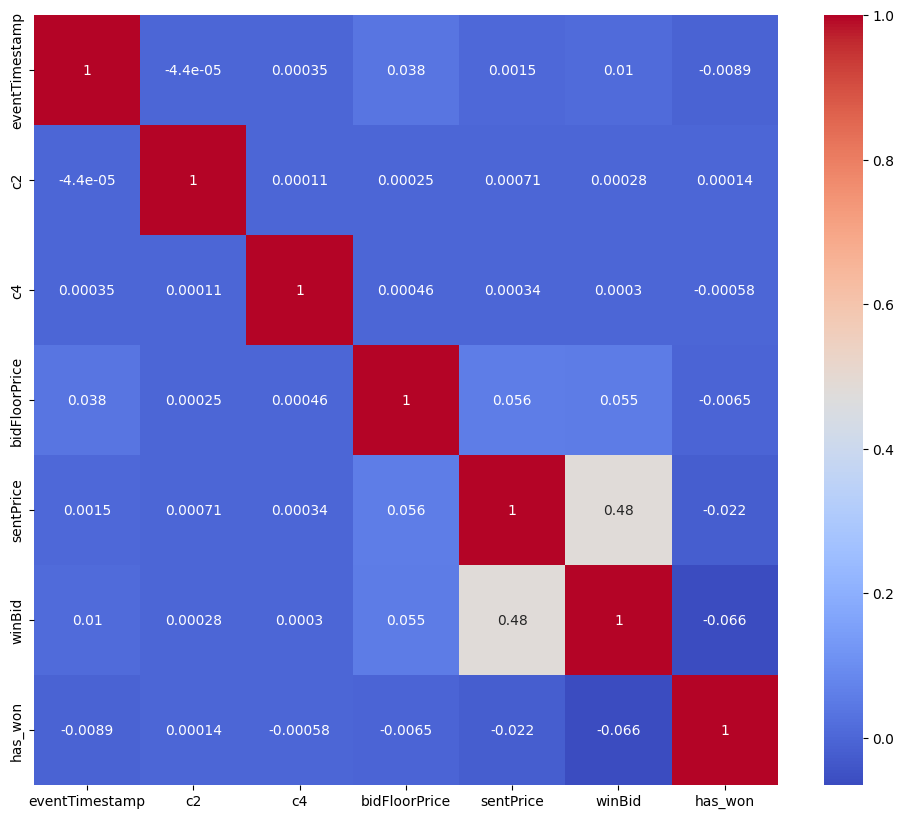

In [7]:
# Select only numeric columns
numeric_cols = train_data.select_dtypes(include=[np.number])

plt.figure(figsize=(12,10))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.show()


/Users/orki/code/ds/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


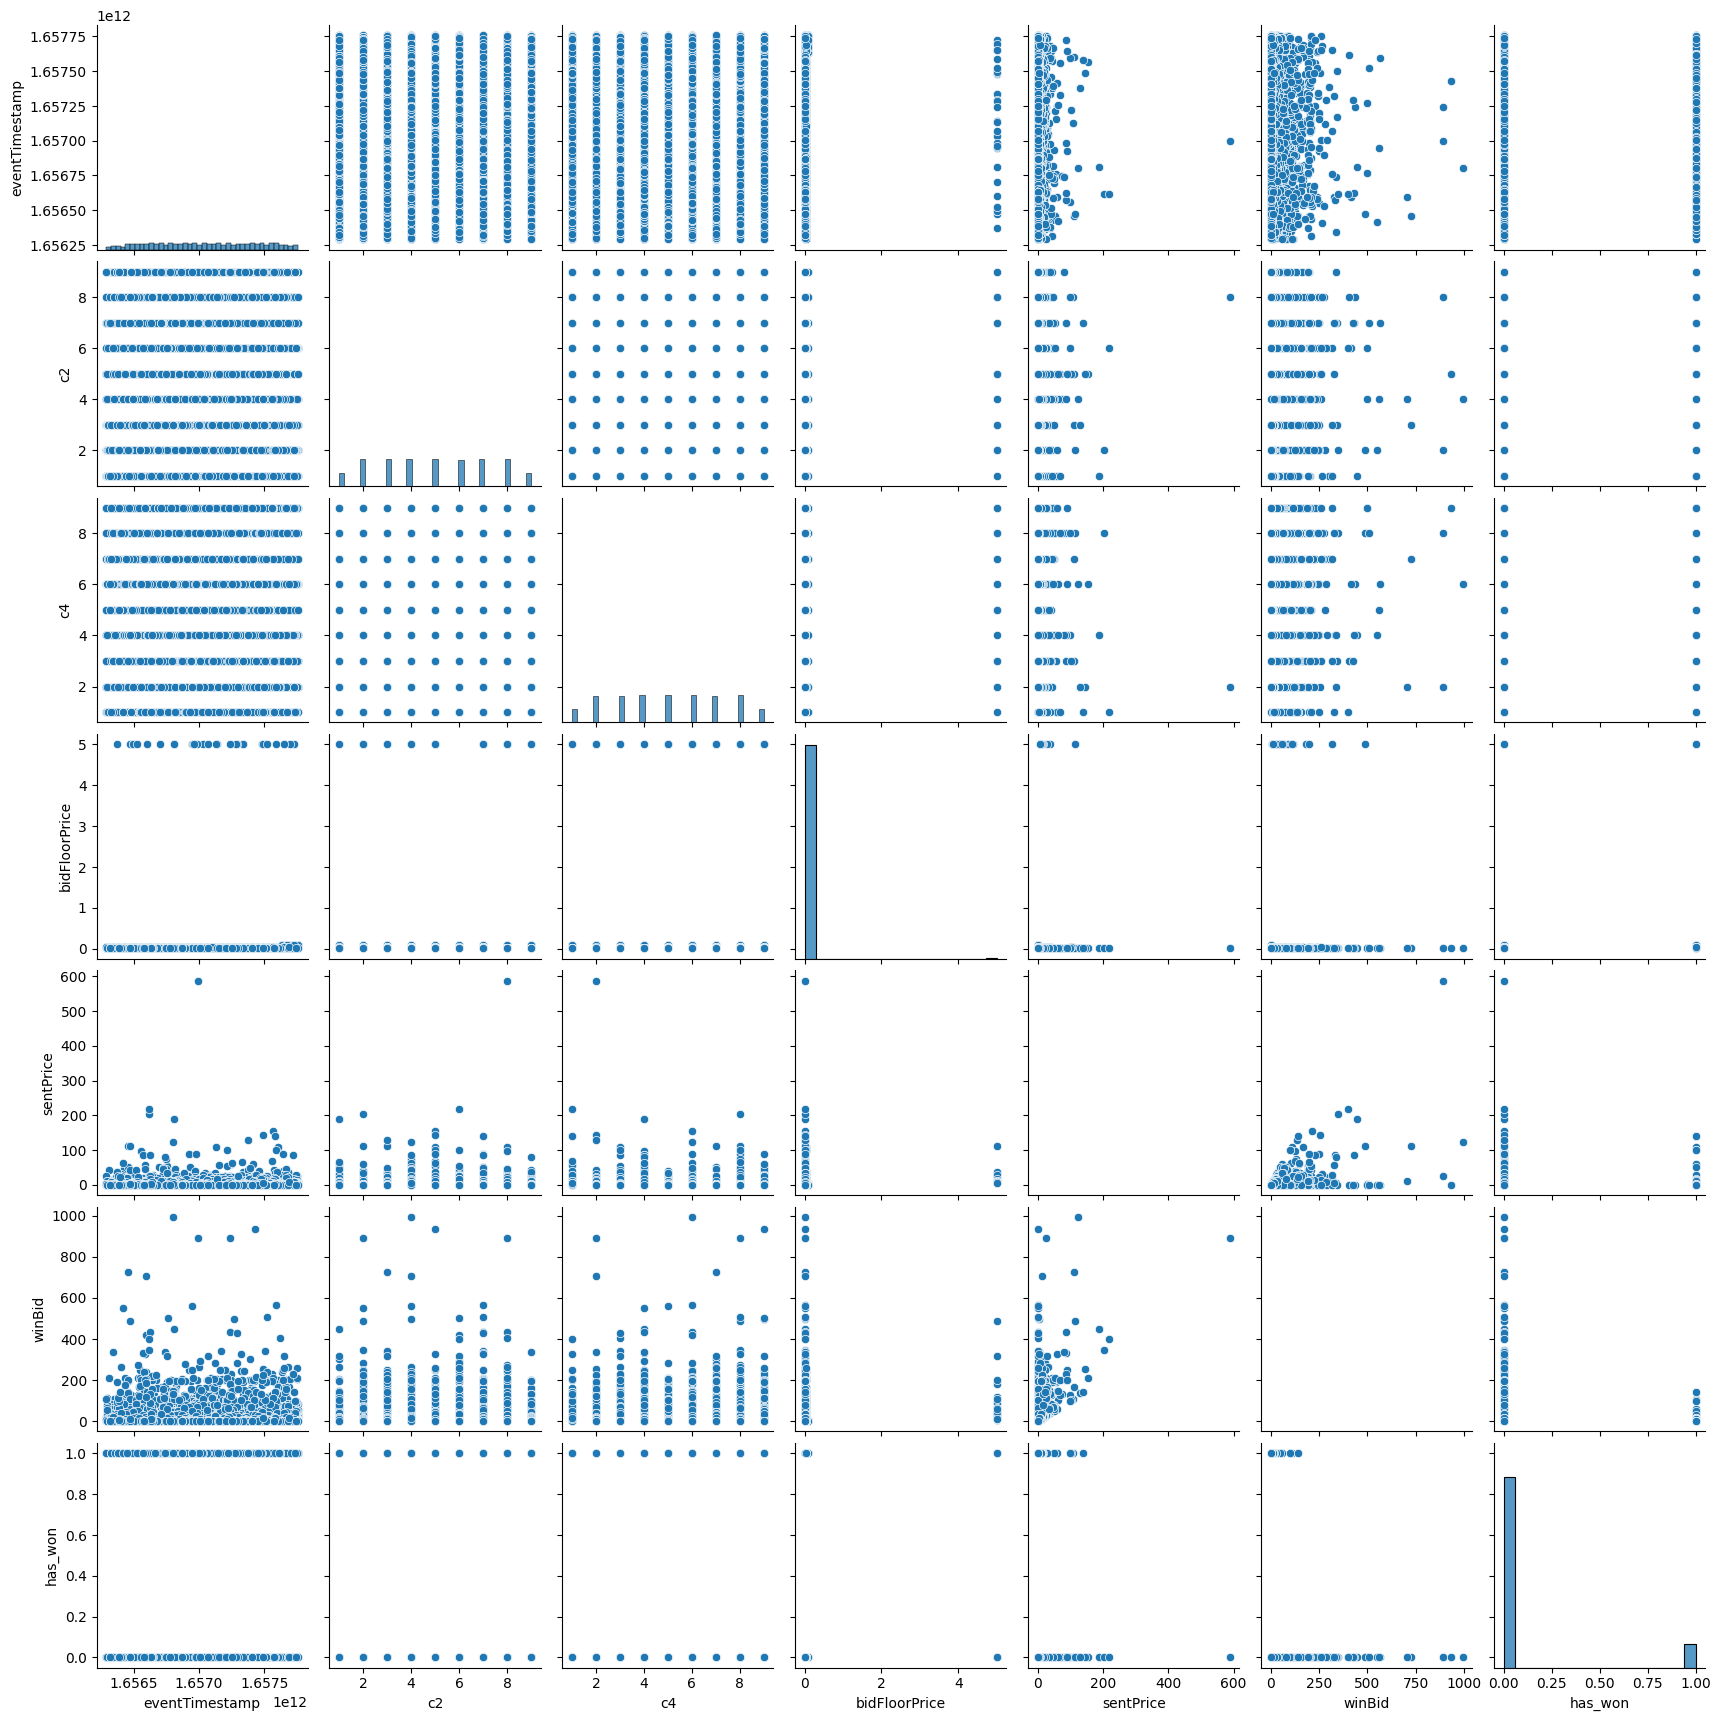

In [8]:
sns.pairplot(numeric_cols.sample(50000))

array([[<Axes: title={'center': 'c2'}>, <Axes: title={'center': 'c4'}>]],
      dtype=object)

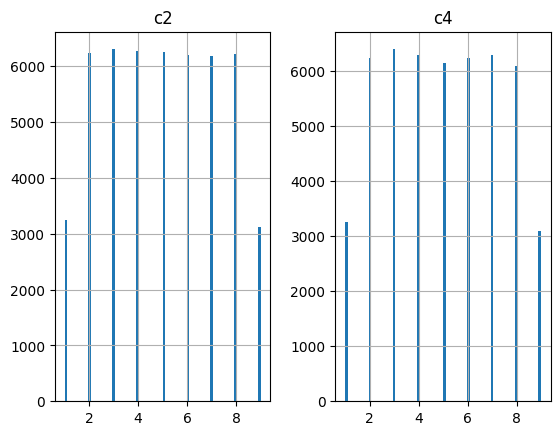

In [9]:
train_data[['c2', 'c4']].sample(50000).hist(bins='rice')

Target Variable Distribution

/Users/orki/code/ds/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


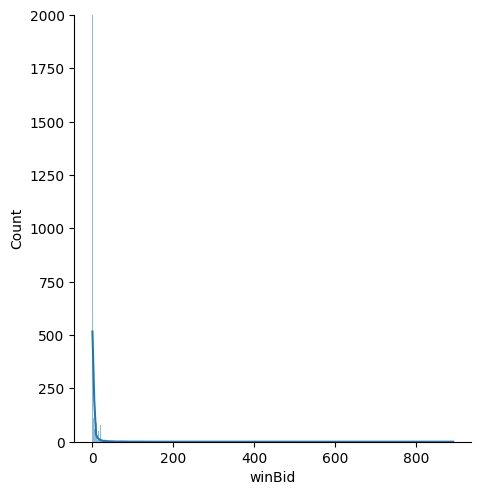

In [10]:
sns.displot(train_data['winBid'].sample(50000), kde=True)
plt.ylim(0,2000)
plt.show()


/Users/orki/code/ds/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


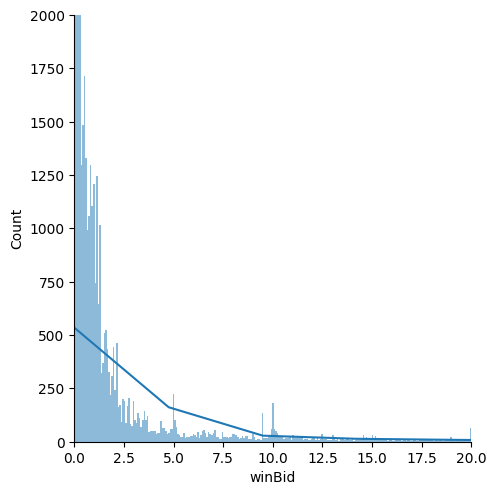

In [11]:
sns.displot(train_data['winBid'].sample(50000), kde=True)
plt.ylim(0,2000)
plt.xlim(0,20)
plt.show()


Categorical Variables Distribution

In [12]:
for col in train_data.select_dtypes(include=['object']).columns:
    print(train_data[col].value_counts())

unitDisplayType
banner          5785775
rewarded         848254
interstitial     687604
Name: count, dtype: int64
brandName
Generic     2088820
Samsung     1749701
Apple       1489130
Motorola     552553
Huawei       362583
             ...   
Axia              3
Leagoo            2
Treswave          2
FNB               1
Tichips           1
Name: count, Length: 144, dtype: int64
bundleId
com.loop.match3d               4505172
1502447854                     1186861
com.tilegarden.match3           805433
se.ace.fishinc                  190584
1529614832                      135974
com.tintash.nailsalon           134457
1523081624                      104315
com.AppIdeas.LevelUpRunner       62044
com.kamilbilge.ropesavior3d      53746
1436213906                       32046
com.YayySAL.DodgeAgent           29127
com.volt.dresstoimpress          27144
dovi.coalmining.inc              24796
1586795332                       15478
1542256628                        6392
1579489488             

In [13]:
train_data_sample = train_data.sample(50000)

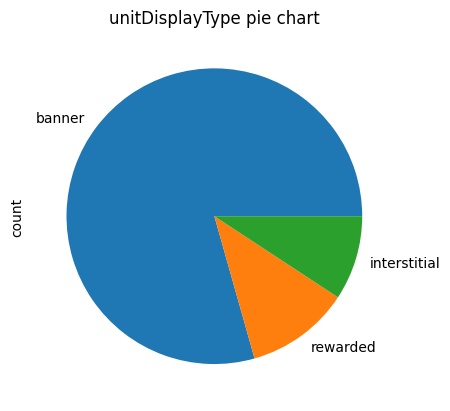

<Figure size 1600x600 with 0 Axes>

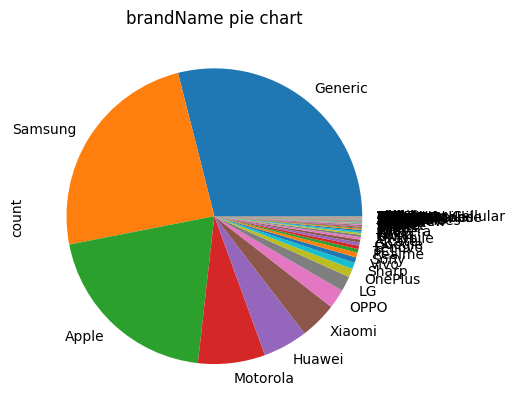

<Figure size 1600x600 with 0 Axes>

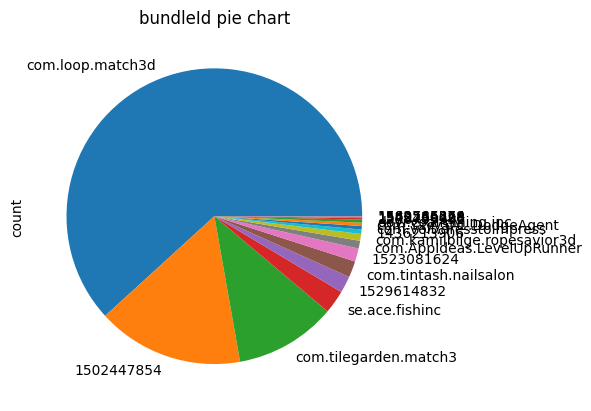

<Figure size 1600x600 with 0 Axes>

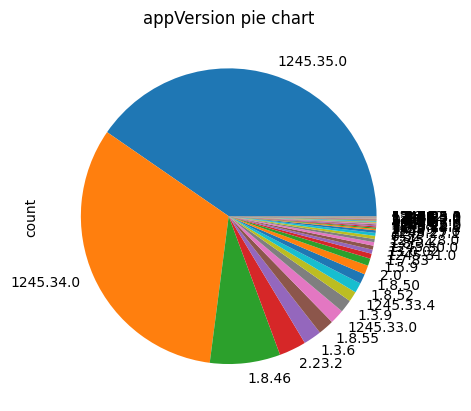

<Figure size 1600x600 with 0 Axes>

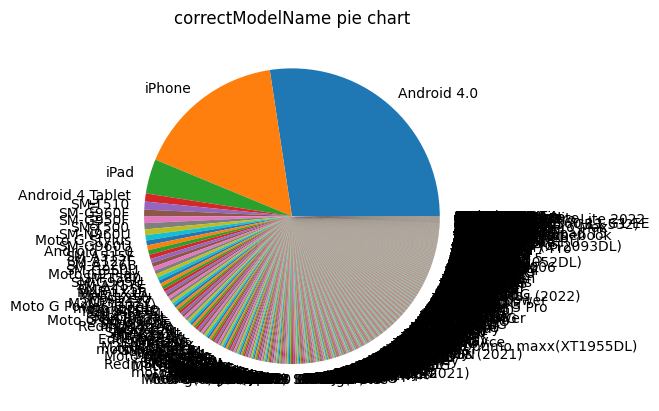

<Figure size 1600x600 with 0 Axes>

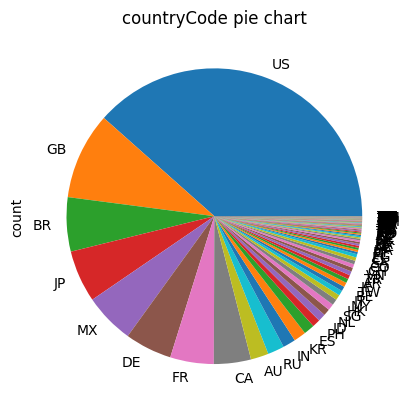

<Figure size 1600x600 with 0 Axes>

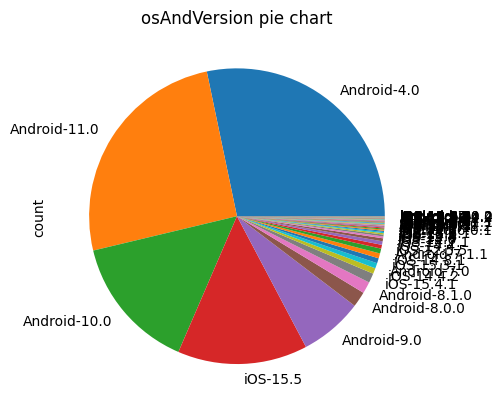

<Figure size 1600x600 with 0 Axes>

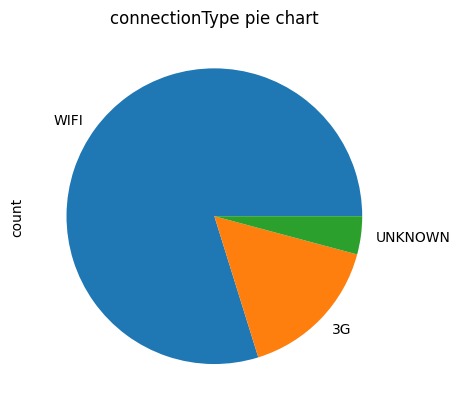

<Figure size 1600x600 with 0 Axes>

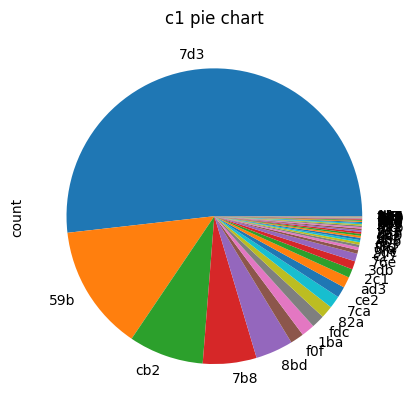

<Figure size 1600x600 with 0 Axes>

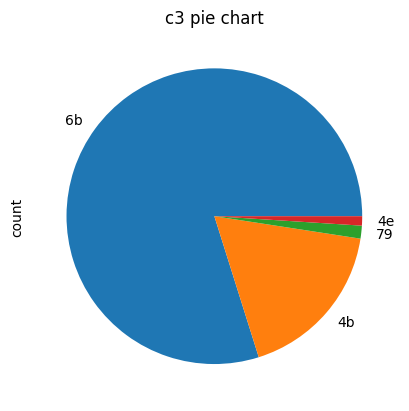

<Figure size 1600x600 with 0 Axes>

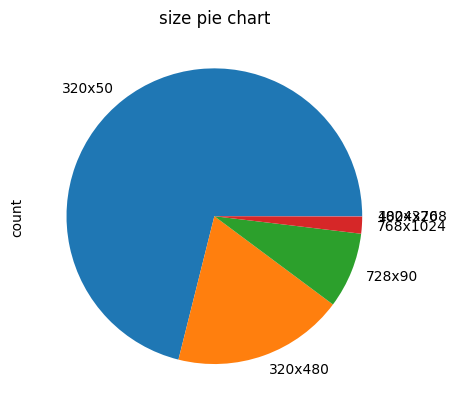

<Figure size 1600x600 with 0 Axes>

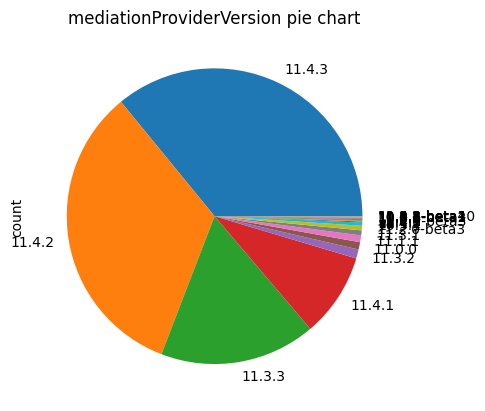

<Figure size 1600x600 with 0 Axes>

In [14]:
for col in train_data_sample.drop(['deviceId'], axis=1).select_dtypes(include=['object']).columns:
    train_data_sample[col].value_counts().plot(kind='pie')
    plt.title(f'{col} pie chart')
    plt.figure(figsize=(16, 6))
    plt.show()

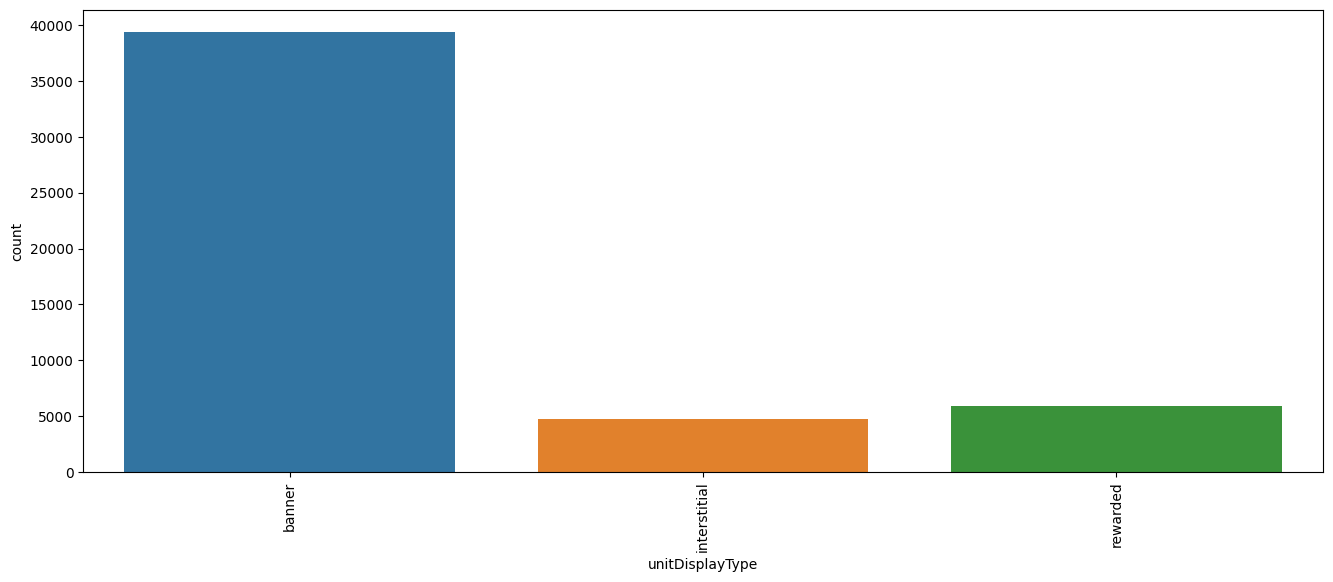

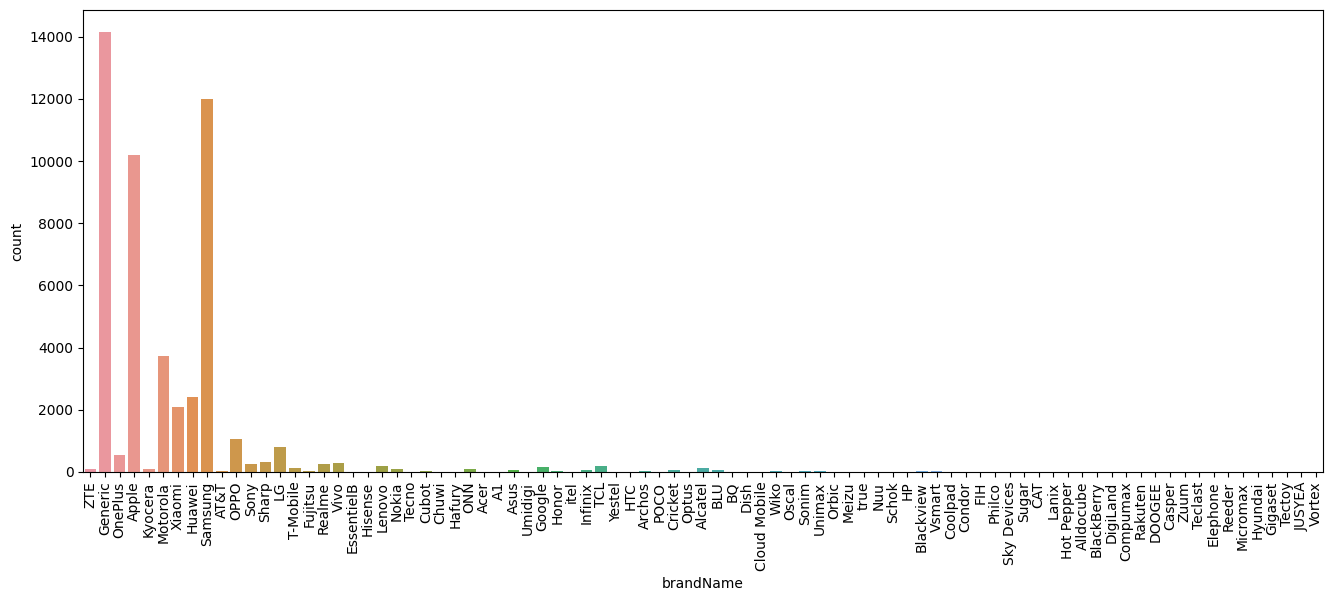

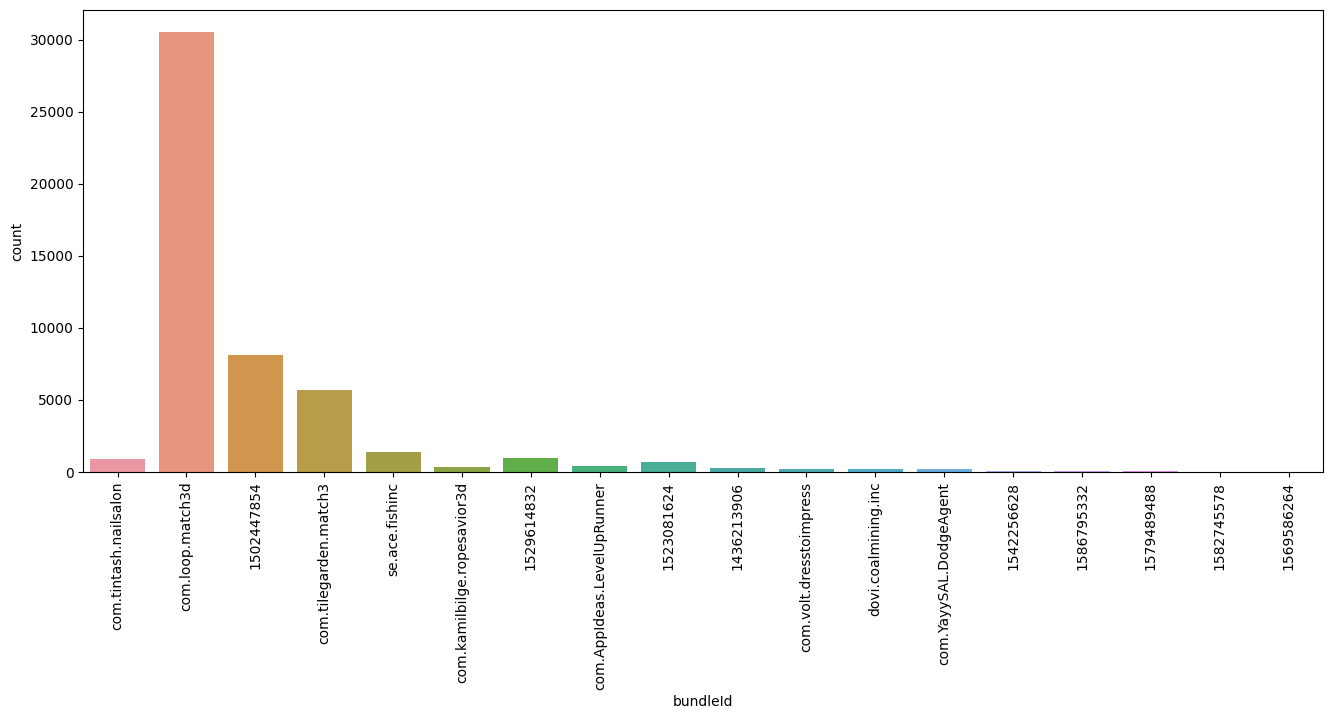

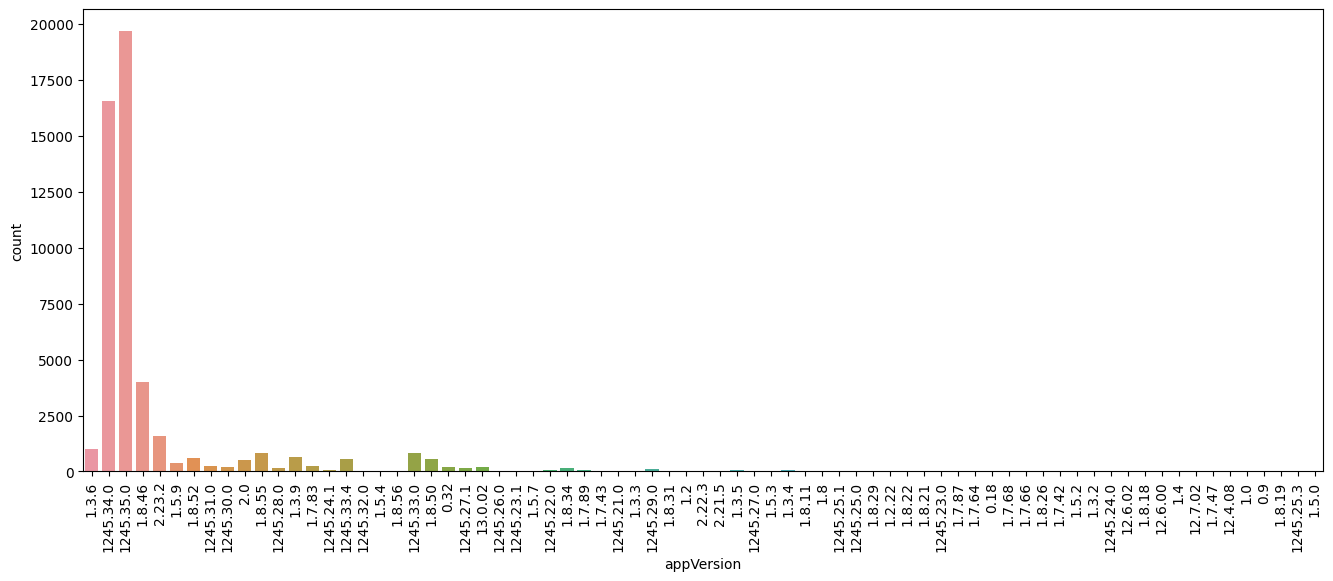

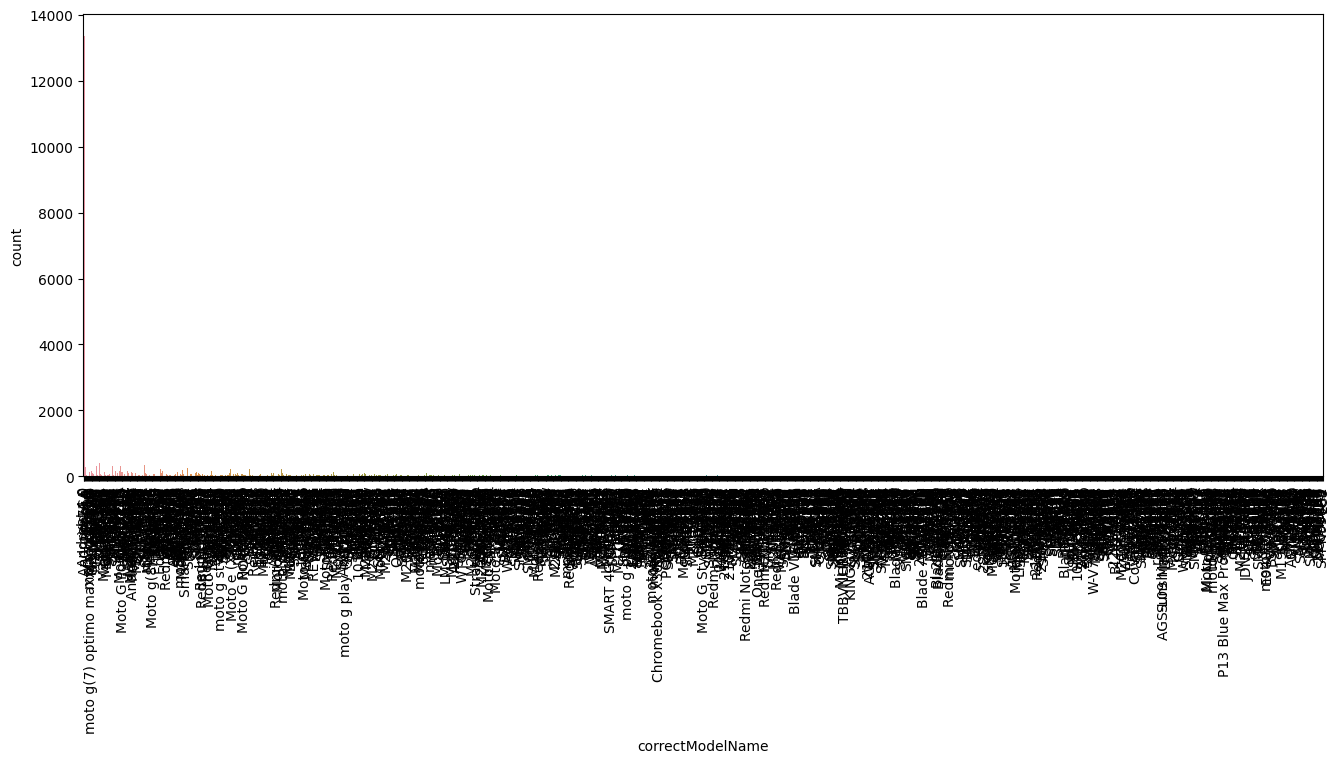

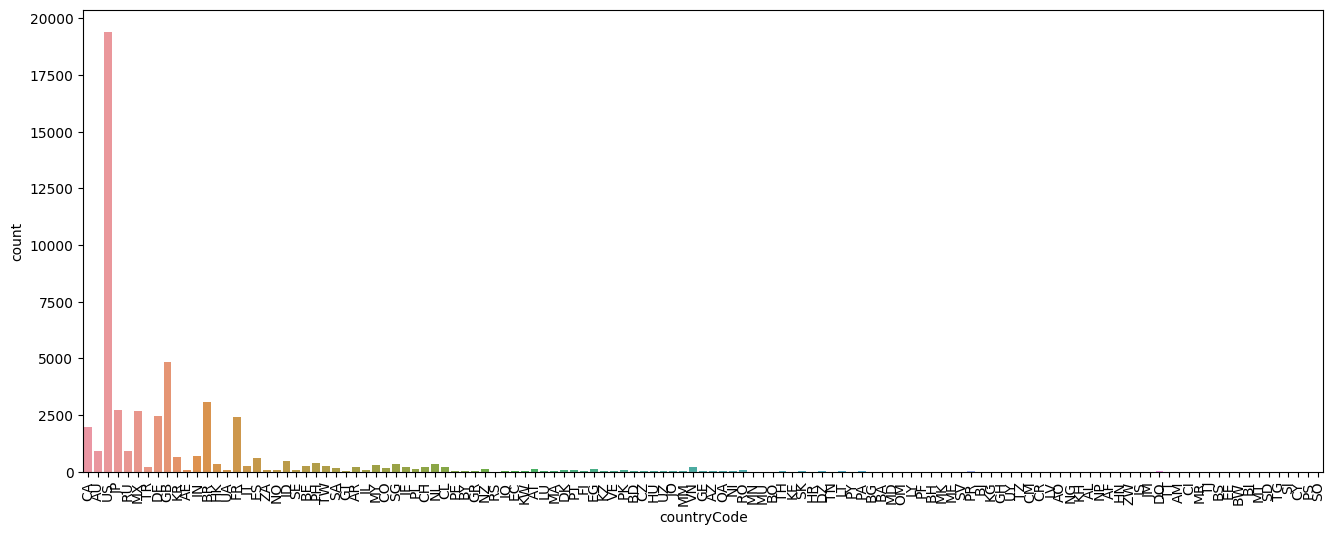

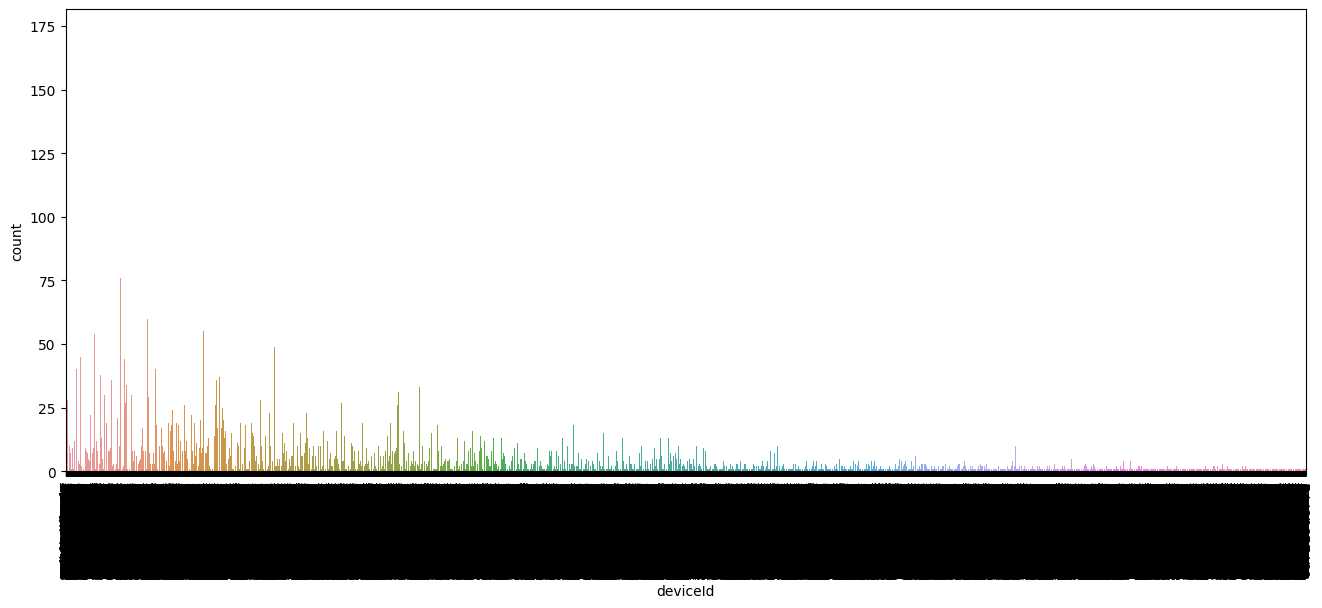

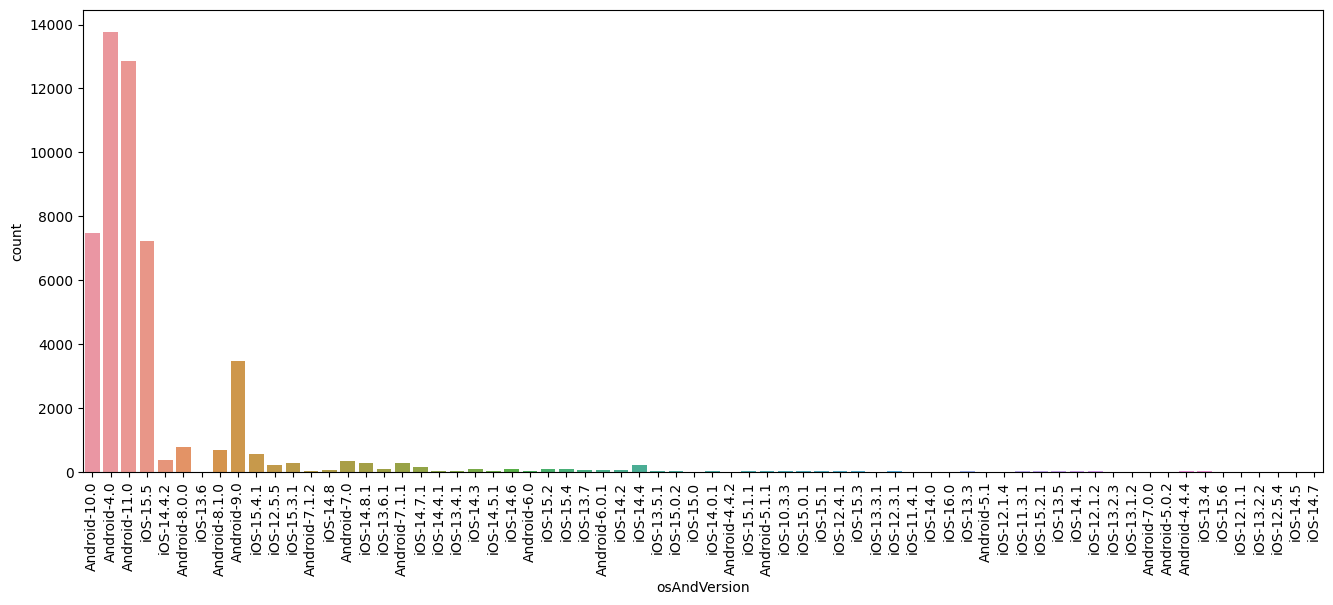

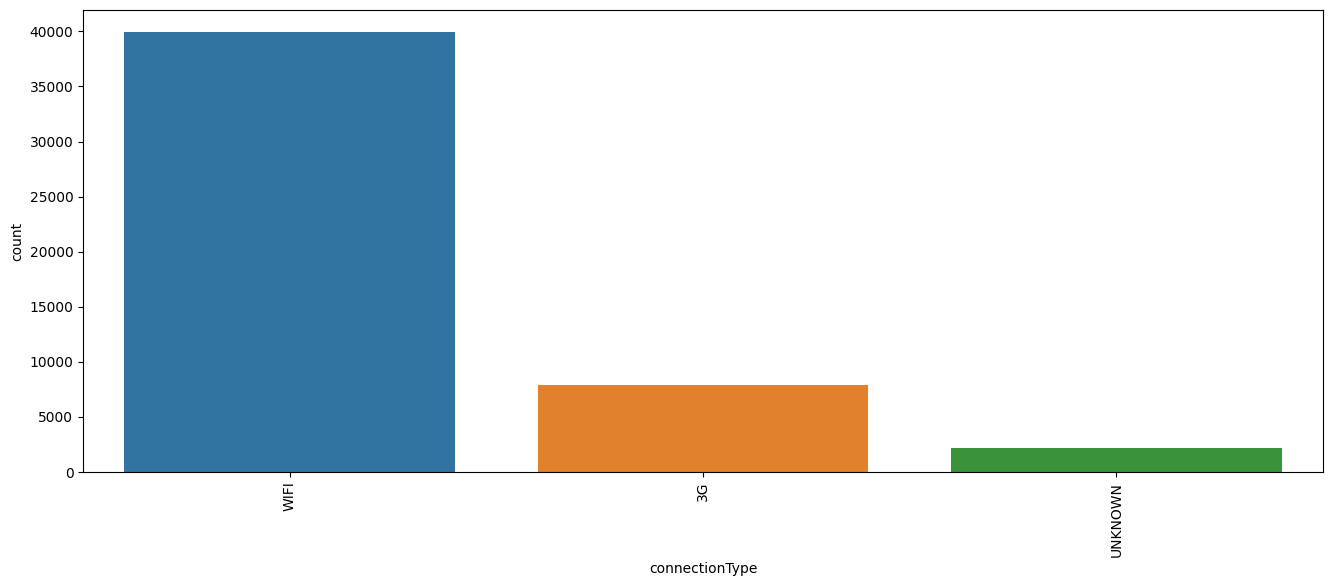

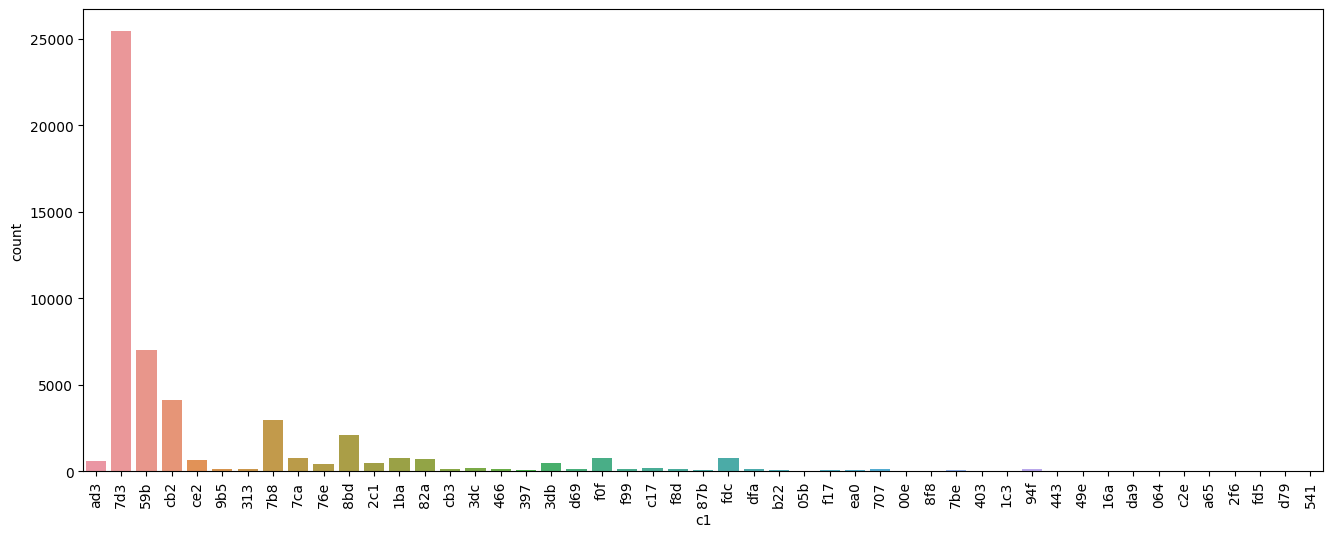

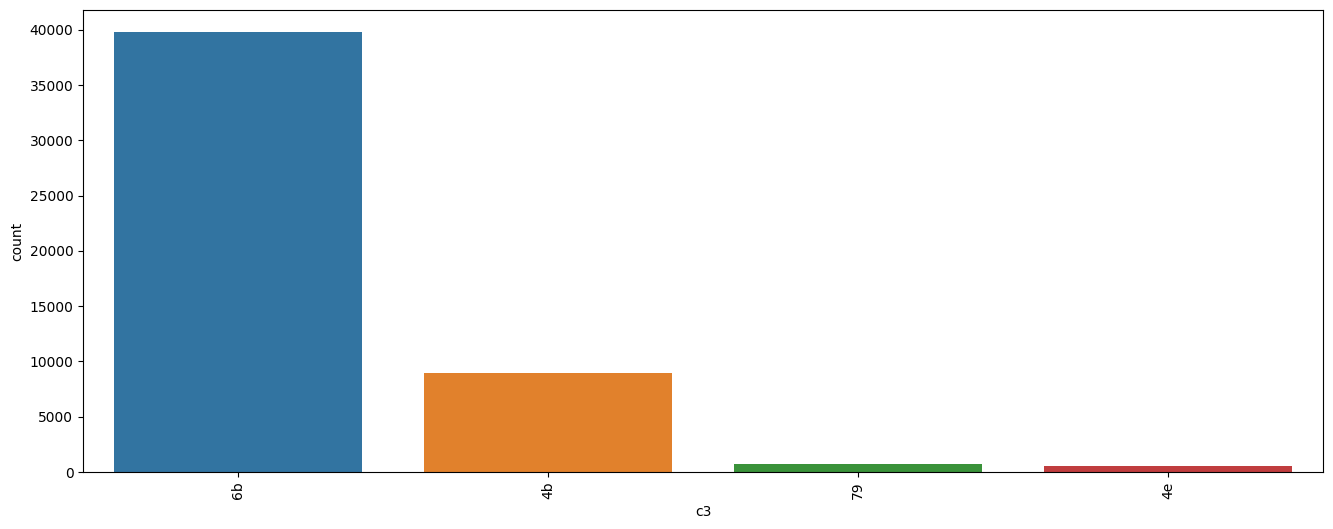

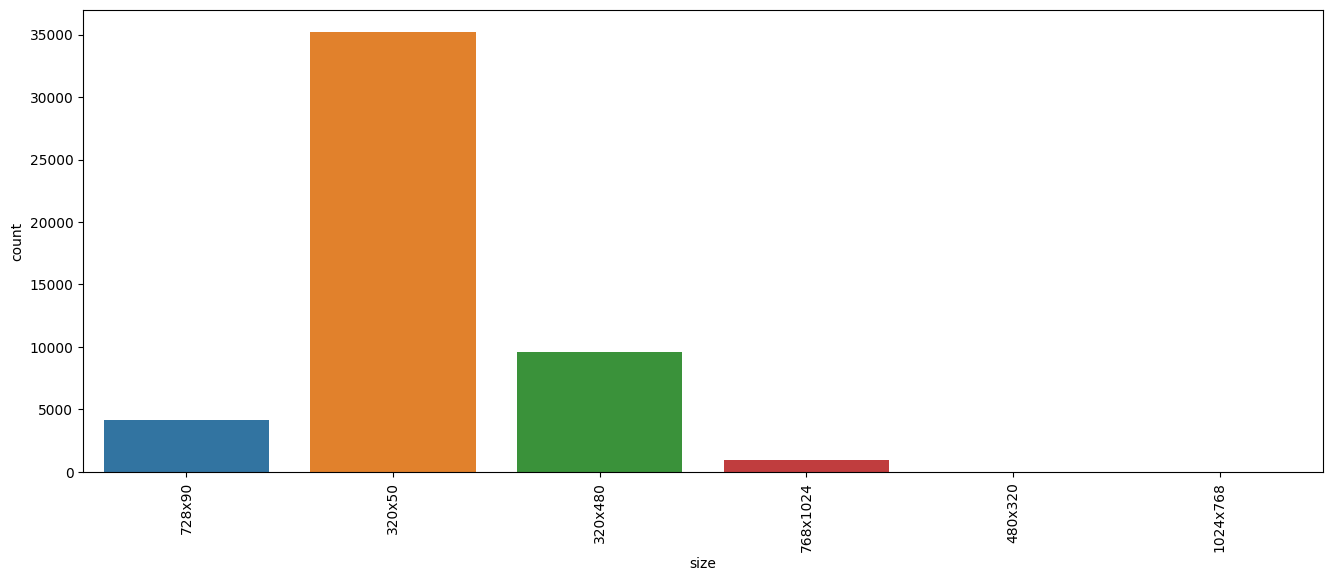

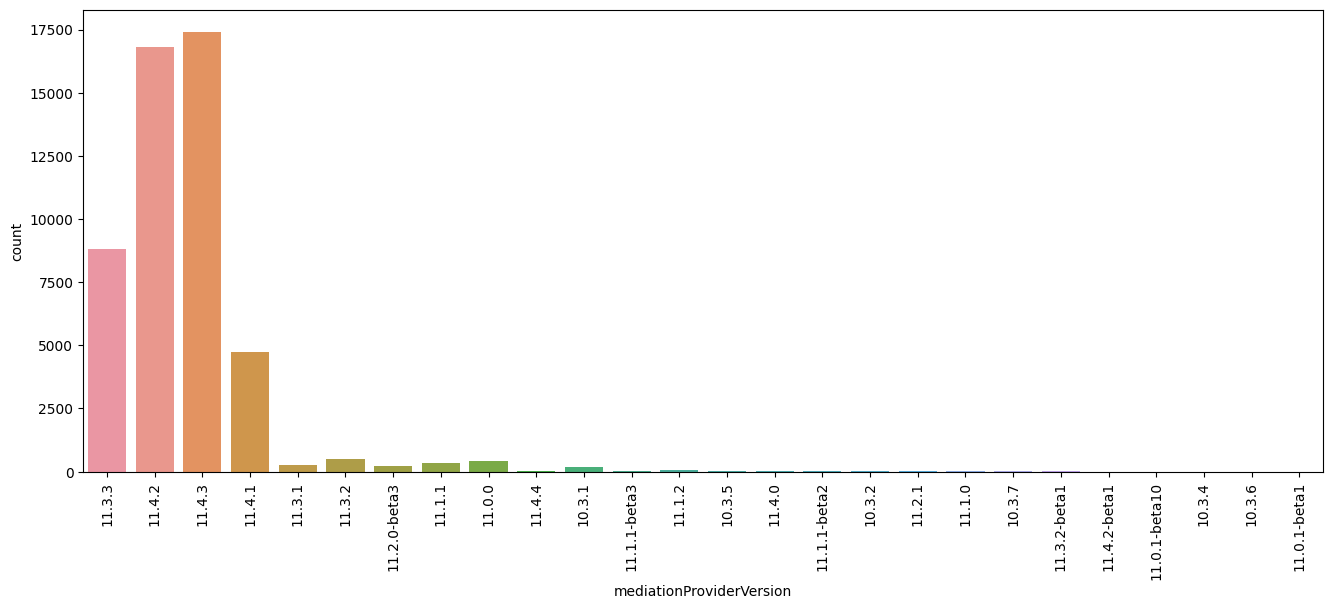

In [15]:
train_data_sample = train_data.sample(50000)
for col in train_data_sample.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(16, 6))
    sns.countplot(data=train_data_sample, x=col)
    plt.xticks(rotation=90)
    plt.show()

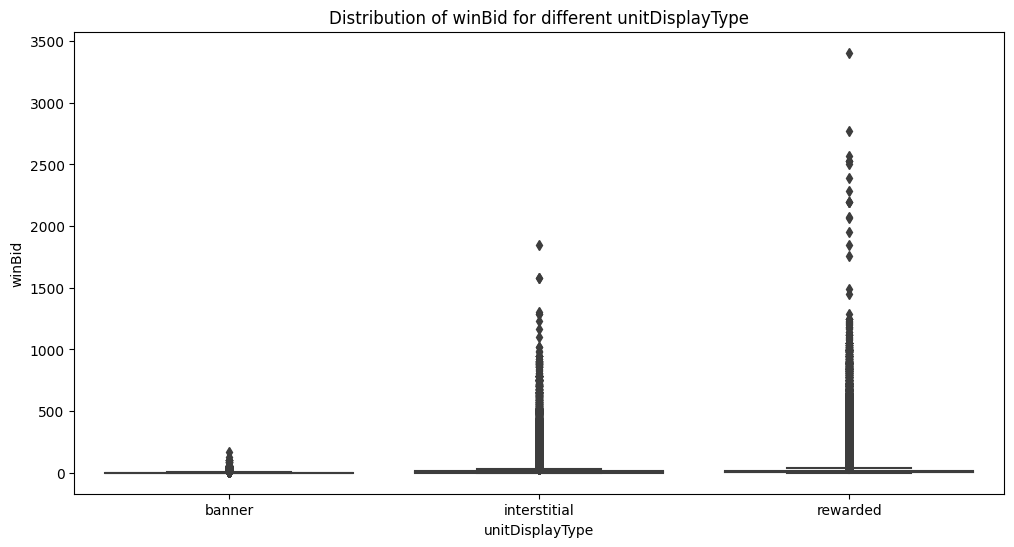

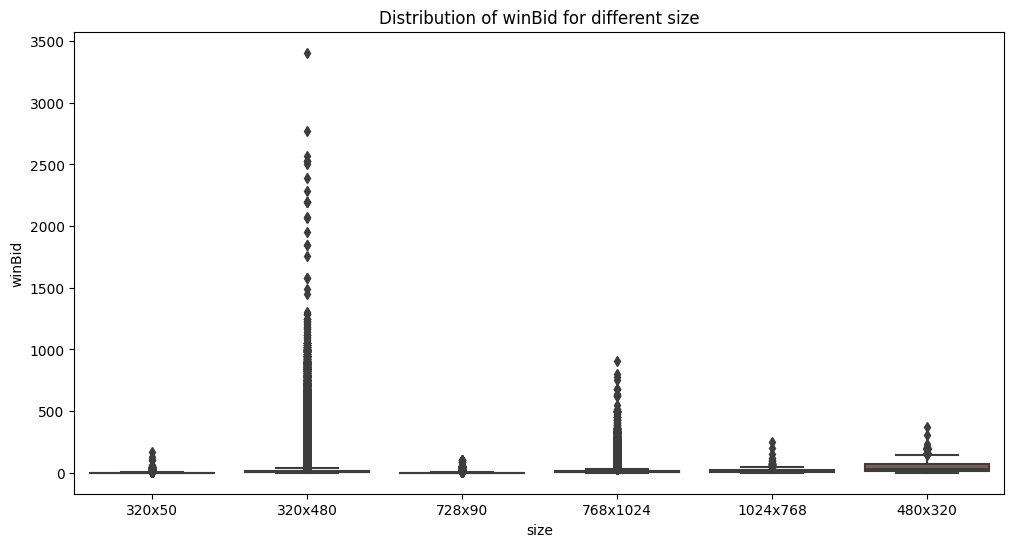

In [16]:
# Categorical Features
cat_cols_low_card = ['unitDisplayType', 'size']

# Boxplots for each categorical feature vs target
for col in cat_cols_low_card:
    plt.figure(figsize=(12,6))
    sns.boxplot(x=col, y='winBid', data=train_data)
    plt.title(f"Distribution of winBid for different {col}")
    plt.show()

In [17]:

# High Cardinality Categorical Features
high_cardinality_cols = ['brandName', 'bundleId', 'appVersion', 'countryCode', 'osAndVersion', 'c1', 'deviceId', 'correctModelName']
# Investigate unique values and top categories in high cardinality features
for col in high_cardinality_cols:
    print(f"Number of unique values in {col}: {train_data[col].nunique()}")
    print(f"Top 5 categories in {col}:")
    print(train_data[col].value_counts().head(5))
    print("\n")

    # You can use Spearman rank correlation for ordinal variables or if there are many repeated values in your features
    train_data[col] = train_data[col].astype('category')
    train_data[col] = train_data[col].cat.codes
    spearman_corr, _ = spearmanr(train_data[col], train_data['winBid'])
    print(f'Spearman correlation of winBid and {col} : {spearman_corr}\n')

    # In case of a numeric target variable and a high cardinality categorical variable, we can also apply Kruskal-Wallis H Test
    from scipy.stats import kruskal
    H, pval = kruskal(*[group["winBid"].values for name, group in train_data.groupby(col)])
    print(f'Kruskal-Wallis H Test for {col} : H={H}, p-value={pval}\n')

Number of unique values in brandName: 144
Top 5 categories in brandName:
brandName
Generic     2088820
Samsung     1749701
Apple       1489130
Motorola     552553
Huawei       362583
Name: count, dtype: int64


Spearman correlation of winBid and brandName : -0.07520419761194229

Kruskal-Wallis H Test for brandName : H=426939.9836532866, p-value=0.0

Number of unique values in bundleId: 18
Top 5 categories in bundleId:
bundleId
com.loop.match3d         4505172
1502447854               1186861
com.tilegarden.match3     805433
se.ace.fishinc            190584
1529614832                135974
Name: count, dtype: int64


Spearman correlation of winBid and bundleId : 0.12796018332815248

Kruskal-Wallis H Test for bundleId : H=522753.09475848934, p-value=0.0

Number of unique values in appVersion: 101
Top 5 categories in appVersion:
appVersion
1245.35.0    2911851
1245.34.0    2424607
1.8.46        561931
2.23.2        217127
1.3.6         148394
Name: count, dtype: int64


Spearman correlati

There are no missing values in most columns except 'countryCode' and 'connectionType' which have 27 and 666 missing entries, respectively.   

The numerical variables such as 'eventTimestamp', 'c2', 'c4', 'bidFloorPrice', 'sentPrice', 'winBid', and 'has_won' show a broad range of values with varying means and standard deviations.  
However, it's notable that 'bidFloorPrice' and 'sentPrice' have a skewed distribution with a very large maximum value compared to the mean,  
suggesting the presence of outliers. These outliers may need to be handled carefully during modeling to prevent them from skewing the model's predictions.

The categorical variables in the data exhibit varying degrees of cardinality (number of unique values).   
Some variables like 'deviceId' and 'correctModelName' have a high cardinality with thousands of unique values,   
while others like 'unitDisplayType', 'connectionType', 'c3', and 'size' have only a few unique values.  

For many of these categorical variables, a small number of categories represent the majority of the data. For example, in 'brandName',   
the top three brands ('Generic', 'Samsung', 'Apple') account for a large portion of the total. 

In terms of geography, 'US', 'GB', and 'BR' are the most represented countries in the data.  

Based on these observations, the data seems well-structured overall, but will likely need some preprocessing to handle outliers, missing values, and categorical variables.   
Finally, feature selection or feature encoding might be necessary given the high cardinality of some variables.